In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import glob
import os
import seaborn as sns
import tensorflow as tf
import scipy
import glob
import sklearn 
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import layers, models, optimizers
from tensorflow.keras.layers import Input, Activation, Dense, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.optimizers import Adam, SGD
from keras_tuner import BayesianOptimization, HyperParameters

2024-01-26 12:29:05.342738: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-26 12:29:05.342776: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-26 12:29:05.342807: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-26 12:29:05.350868: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-26 12:29:06.354685: W tensorflow/compiler/tf2t

***
### Clustering

In [2]:
folder_name_1 = 'AET_CF_Trial_12'
file_name_1 = '12_LSP_AET_CF_Predictions56'

folder_name_2 = 'AET_CF_1_Cluster_Trial_1'
if not os.path.exists(folder_name_2):
    os.makedirs(folder_name_2)
file_name_2 = '1_LSP_AET_CF_'

In [3]:
# read in and plot the original data set
latent = pd.read_pickle(f'{folder_name_1}/{file_name_1}')
latent = latent.replace({'trajectory-0.0': 0, 'trajectory-1.0': 1})

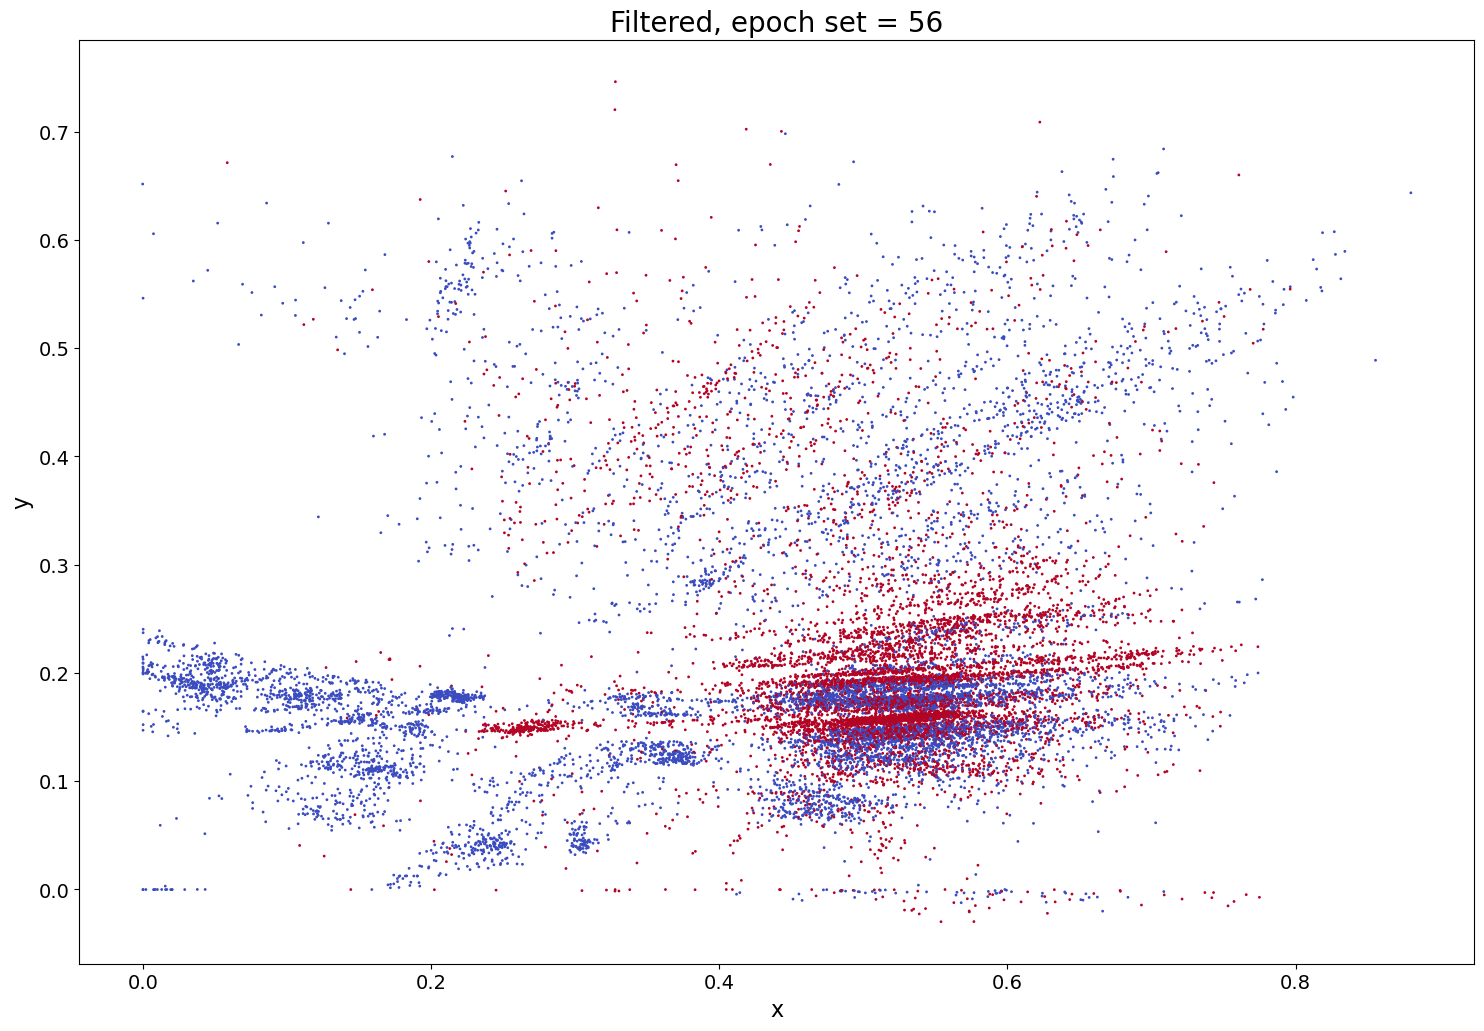

In [4]:
plt.figure(figsize=(18,12))
plt.scatter (latent.x,latent.y, c=latent.z, cmap="coolwarm", s = 1, alpha=1)
plt.title('Filtered, epoch set = 56', fontsize = 20)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize=16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize=14)
# plt.savefig("56_data.png", dpi = 300)

plt.show()

In [5]:
# remove the trajectory identity column for further processing
latent_n = latent.drop(['z', 'index'], axis = 1)
print(latent_n)

              x         y
0      0.435840  0.182651
1      0.488385  0.183984
2      0.464089  0.128205
3      0.500894  0.146142
4      0.611763  0.427122
...         ...       ...
15995  0.506691  0.363621
15996  0.554290  0.159798
15997  0.565002  0.205167
15998  0.576408  0.253255
15999  0.158209  0.102874

[16000 rows x 2 columns]


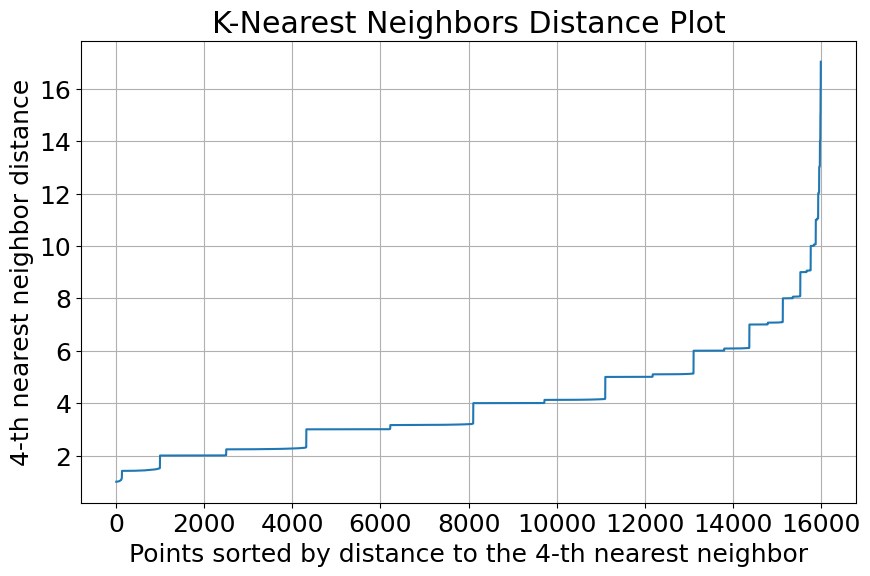

In [20]:
def plot_knn_distances(latent_n, k=4):
    """
    Plot the k-nearest neighbors distance for each point in the dataset to help
    determine a good 'eps' value for DBSCAN.

    Parameters:
    - data: The dataset (as a numpy array or similar).
    - k: The number of neighbors to consider (typically the same as 'min_samples' in DBSCAN).
    """
    # Compute the nearest neighbors
    nn = NearestNeighbors(n_neighbors=k).fit(latent_n)
    distances, _ = nn.kneighbors(latent_n)

    # Sort and plot the distances
    sorted_distances = np.sort(distances[:, k-1], axis=0)
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_distances)
    plt.xlabel('Points sorted by distance to the {}-th nearest neighbor'.format(k))
    plt.ylabel('{}-th nearest neighbor distance'.format(k))
    plt.title('K-Nearest Neighbors Distance Plot')
    plt.grid(True)
    plt.show()

# Then call the function with your data
# plot_knn_distances(df55.values, k=4) 


plot_knn_distances(latent.values, k=4)  # Adjust 'k' as needed

Number of clusters: 12


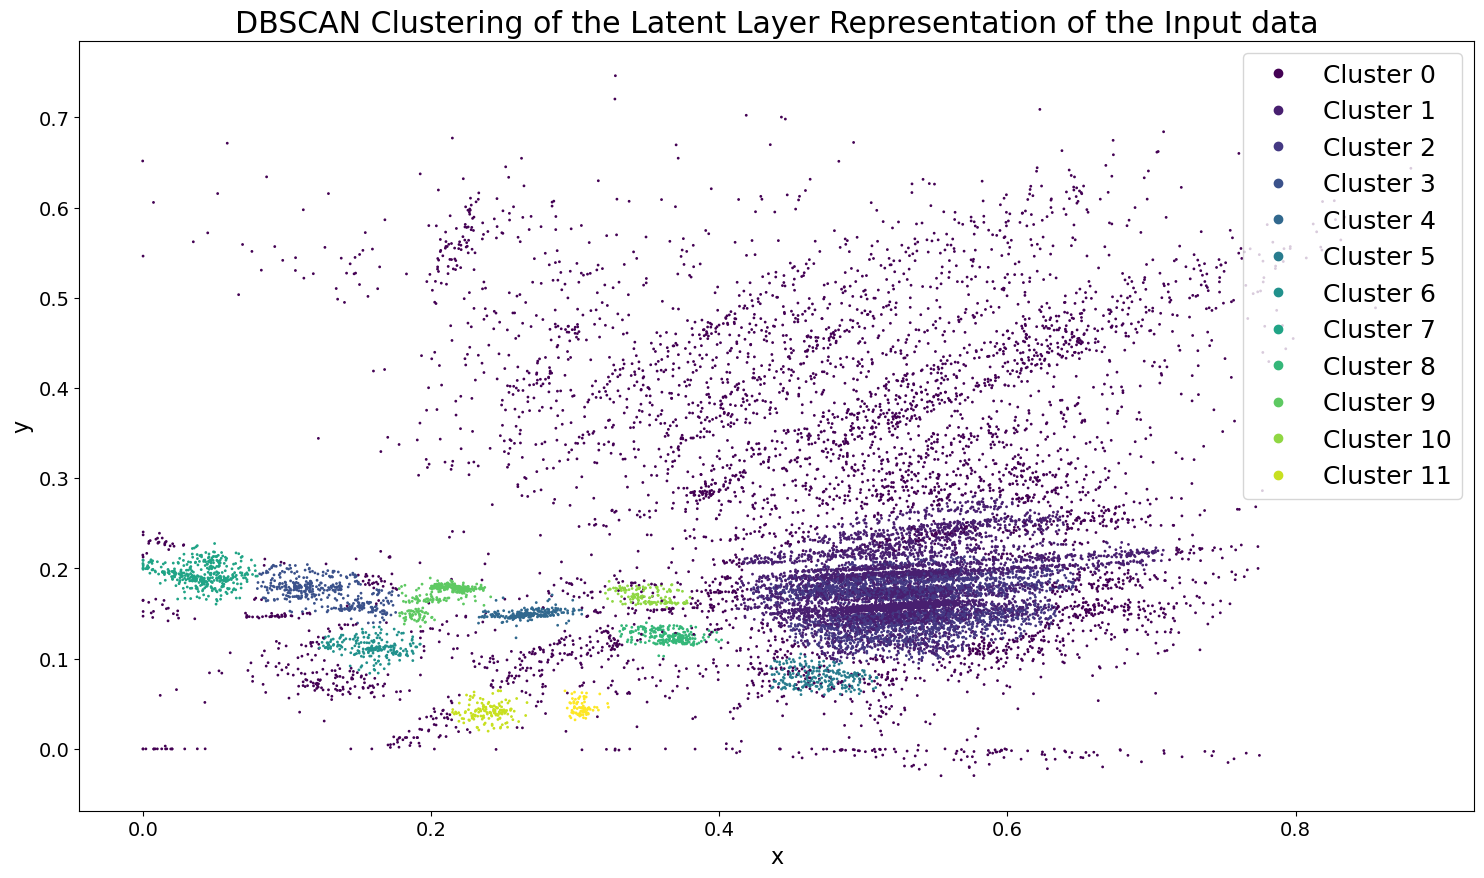

In [21]:
y_pred = DBSCAN(eps=0.015, min_samples=60).fit_predict(latent_n)

plt.rcParams['font.size'] = '18'
plt.figure(figsize=(18,10))

# Scatter plot assigning to a variable
scatter = plt.scatter(latent_n.iloc[:,0], latent_n.iloc[:,1], c=y_pred, s=1)

# Creating a legend
unique_labels = np.unique(y_pred)
# Filter out the noise label (-1) if present
unique_labels = unique_labels[unique_labels != -1]
legend_labels = ['Cluster {}'.format(lbl) for lbl in unique_labels]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, loc='upper right')

# Setting labels, titles, and ticks
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('DBSCAN Clustering of the Latent Layer Representation of the Input data')

# Print the number of clusters
print('Number of clusters: {}'.format(len(unique_labels)))

In [22]:
# latent_n is DataFrame after removing the 'z' column
# latent is the original DataFrame with the 'z' column

# Add the cluster labels to your DataFrame
latent_n['cluster'] = y_pred

# Reattach the 'z' column
latent_n['z'] = latent['z']

# Group by cluster and trajectory identity, then count the occurrences
cluster_trajectory_count = latent_n.groupby(['cluster', 'z']).size().reset_index(name='count')

print(cluster_trajectory_count)

    cluster  z  count
0        -1  0   3062
1        -1  1   1934
2         0  1   5816
3         1  0   2808
4         2  0    382
5         3  1    250
6         4  0    245
7         5  0    215
8         6  0    383
9         7  0    221
10        8  0    316
11        9  0    142
12       10  0    145
13       11  0     81


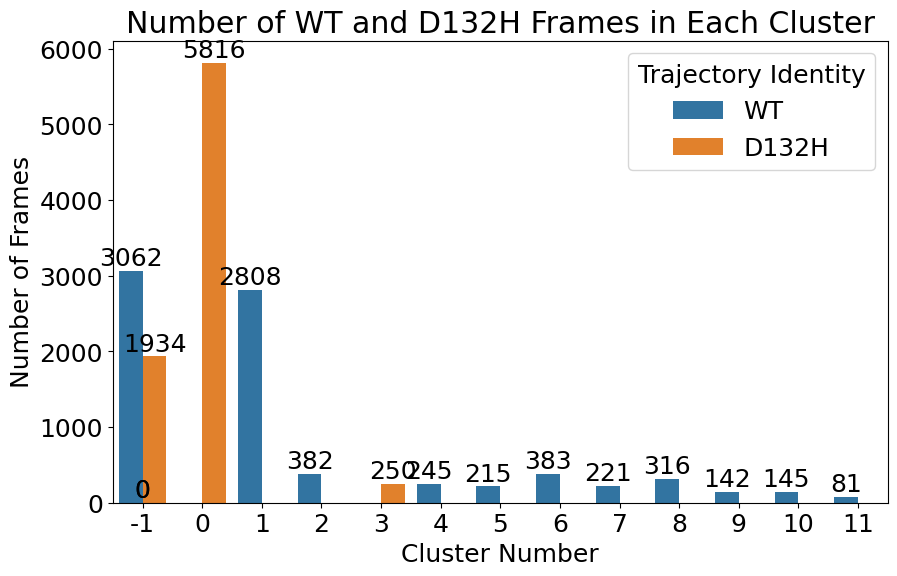

In [23]:
# 0 is WT and 1 is D132H
cluster_trajectory_count['z'] = cluster_trajectory_count['z'].replace({0: 'WT', 1: 'D132H'})

# Create the bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='cluster', y='count', hue='z', data=cluster_trajectory_count)

# Setting labels and title
plt.xlabel('Cluster Number')
plt.ylabel('Number of Frames')
plt.title('Number of WT and D132H Frames in Each Cluster')
plt.xticks(rotation=0)
plt.legend(title='Trajectory Identity')

# Annotate each bar with its count
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

# Show the plot
plt.show()

In [24]:
# Drop the first 3 columns
latent.drop(latent.columns[:2], axis=1, inplace=True)

# Rename the 'index' column to be the actual index
latent.set_index('index', inplace=True)

# Remove the name of the index column
latent.index.name = None

In [25]:
# Load recluster data
# recluster = pd.read_csv(f'{folder_name_2}/recluster.csv', index_col=0)
y_valid_f = pd.read_csv(f'{folder_name_1}/y_valid_f.csv', index_col=0)
X_valid_f = pd.read_csv(f'{folder_name_1}/X_valid_f.csv', index_col=0)
X_train_f = pd.read_csv(f'{folder_name_1}/X_train_f.csv', index_col=0)

In [26]:
# Read the original data
original_data = pd.read_csv(f'{folder_name_1}/X_valid_f.csv', index_col=0)

cluster_number = 6  # change this to your desired cluster number
selected_cluster_indices = latent_n[latent_n['cluster'] == cluster_number].index

filtered_data = original_data.iloc[selected_cluster_indices]

# Save the filtered data
filtered_data.to_csv(f'{folder_name_2}/Recluster_Latent.csv')

# Save indexes of the filtered data
latent.to_csv(f'{folder_name_2}/Recluster_Index.csv')

Recluster_Latent = pd.read_csv(f'{folder_name_2}/Recluster_Latent.csv', index_col=0)
Recluster_Index = pd.read_csv(f'{folder_name_2}/Recluster_Index.csv', index_col=0)

In [27]:
# Get autoencoder model
def get_ae(train_data, LeReLU_alpha=0.01):
    
    #Input layer
    input_layer = Input(shape=(train_data.shape[1]), name='ae_input')
    
    encoder = Dense(336, activation=LeakyReLU(alpha=LeReLU_alpha), name='e1')(input_layer)
    encoder = Dense(208, activation=LeakyReLU(alpha=LeReLU_alpha), name='e2')(encoder)
    encoder = Dense(240, activation=LeakyReLU(alpha=LeReLU_alpha), name='e3')(encoder)

    encoded = Dense(2, activation=LeakyReLU(alpha=LeReLU_alpha), name='ae_latent')(encoder)
    
    decoder = Dense(240, activation=LeakyReLU(alpha=LeReLU_alpha), name='d1')(encoded)
    decoder = Dense(208, activation=LeakyReLU(alpha=LeReLU_alpha), name='d2')(decoder)
    decoder = Dense(336, activation=LeakyReLU(alpha=LeReLU_alpha), name='d3')(decoder)

    output_layer = Dense(train_data.shape[1], activation=LeakyReLU(alpha=LeReLU_alpha), name='ae_output')(decoder)
    
    model = Model(input_layer, output_layer)

    return model

In [28]:
# Get ae for filtered data
autoencoder = get_ae(X_train_f)

2024-01-25 13:38:13.895200: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [29]:
# Compile the model
autoencoder.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.00001))

In [30]:
for counts in tqdm(range(59)):
    output_path = os.path.join(folder_name_2, file_name_2 + f"Predictions{counts}.txt")
    with open(output_path, "w") as file:
        # Fit the autoencoder model
        history = autoencoder.fit(X_train_f, X_train_f, batch_size=256, epochs=1000,
                                  validation_data=(X_valid_f, X_valid_f), verbose=1)

        # Save training history
        training_history = pd.DataFrame(history.history)
        plt.plot(training_history)
        name_0 = os.path.join(folder_name_2, file_name_2 + "Training_History" + str(counts))
        training_history.to_pickle(name_0)
        name_1 = os.path.join(folder_name_2, file_name_2 + "Training_History" + str(counts) + ".png")
        plt.savefig(name_1, dpi=300)
        plt.clf()

        # Create a model to extract latent space representations
        dr_model = tf.keras.models.Model(inputs=autoencoder.get_layer('ae_input').input,
                                         outputs=autoencoder.get_layer('ae_latent').output)
        dr_model.summary(print_fn=lambda x: file.write(x + '\n'))

        batch_size = 32
        x, y, z, indices = [], [], [], []       
        
# Iterate over recluster data for predictions
        for batch_start in range(0, len(Recluster_Latent), batch_size):
            batch_end = min(batch_start + batch_size, len(Recluster_Latent))
            X_batch = np.array(Recluster_Latent.iloc[batch_start:batch_end])
            y_batch = Recluster_Index.iloc[batch_start:batch_end]
            index_batch = Recluster_Latent.index[batch_start:batch_end]  # Get indices from recluster_data

            op_batch = dr_model.predict(X_batch, verbose=0)

            for i, op in enumerate(op_batch):
                z.append(y_batch.iloc[i]['z'])
                x.append(op[0])
                y.append(op[1])
                indices.append(y_batch.iloc[i].name)
                file.write(f"Prediction {batch_start + i}: {op}\n")

        df = pd.DataFrame()
        df['x'] = x
        df['y'] = y
        df['z'] = ["trajectory" + str(k) for k in z]
        df['index'] = indices
        
        df['z'] = df['z'].astype(str)
        plt.figure(figsize=(8, 6))
        fig = sns.scatterplot(x='x', y='y', hue='z', data=df, s=10)
        name_2 = os.path.join(folder_name_2, file_name_2 + 'Predictions' + str(counts) + ".png")
        fig.figure.savefig(name_2, dpi=300)
        plt.clf()

        name_3 = os.path.join(folder_name_2, file_name_2 + 'Predictions' + str(counts))
        df.to_pickle(name_3)

        # Save the model
        model_folder = os.path.join(folder_name_2, 'models')
        if not os.path.exists(model_folder):
            os.makedirs(model_folder)
        file_name = os.path.join(model_folder, 'saved_model_' + file_name_2 + str(counts))
        autoencoder.save(file_name)


  0%|                                                    | 0/59 [00:00<?, ?it/s]

Epoch 1/1000
250/250 [==============================] - 3s 6ms/step - loss: 0.0170 - val_loss: 0.0088
Epoch 2/1000
250/250 [==============================] - 2s 7ms/step - loss: 0.0070 - val_loss: 0.0037
Epoch 3/1000
250/250 [==============================] - 2s 7ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 4/1000
250/250 [==============================] - 1s 5ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 5/1000
250/250 [==============================] - 1s 5ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 6/1000
250/250 [==============================] - 1s 5ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 7/1000
250/250 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 9.6043e-04
Epoch 8/1000
250/250 [==============================] - 1s 5ms/step - loss: 8.8403e-04 - val_loss: 8.3726e-04
Epoch 9/1000
250/250 [==============================] - 1s 5ms/step - loss: 8.0902e-04 - val_loss: 7.9013e-04
Epoch 10/1000
250/250 [==============================] - 1s 5m

250/250 [==============================] - 1s 5ms/step - loss: 4.5618e-04 - val_loss: 4.5641e-04
Epoch 149/1000
250/250 [==============================] - 1s 5ms/step - loss: 4.5542e-04 - val_loss: 4.5563e-04
Epoch 150/1000
250/250 [==============================] - 1s 5ms/step - loss: 4.5479e-04 - val_loss: 4.5486e-04
Epoch 151/1000
250/250 [==============================] - 1s 5ms/step - loss: 4.5421e-04 - val_loss: 4.5555e-04
Epoch 152/1000
250/250 [==============================] - 2s 6ms/step - loss: 4.5362e-04 - val_loss: 4.5362e-04
Epoch 153/1000
250/250 [==============================] - 1s 5ms/step - loss: 4.5312e-04 - val_loss: 4.5329e-04
Epoch 154/1000
250/250 [==============================] - 1s 5ms/step - loss: 4.5264e-04 - val_loss: 4.5271e-04
Epoch 155/1000
250/250 [==============================] - 1s 5ms/step - loss: 4.5205e-04 - val_loss: 4.5188e-04
Epoch 156/1000
250/250 [==============================] - 1s 5ms/step - loss: 4.5148e-04 - val_loss: 4.5170e-04
Epoch 1

250/250 [==============================] - 1s 5ms/step - loss: 4.0670e-04 - val_loss: 4.0906e-04
Epoch 295/1000
250/250 [==============================] - 1s 5ms/step - loss: 4.0675e-04 - val_loss: 4.0884e-04
Epoch 296/1000
250/250 [==============================] - 1s 5ms/step - loss: 4.0621e-04 - val_loss: 4.0877e-04
Epoch 297/1000
250/250 [==============================] - 1s 5ms/step - loss: 4.0610e-04 - val_loss: 4.0899e-04
Epoch 298/1000
250/250 [==============================] - 1s 5ms/step - loss: 4.0608e-04 - val_loss: 4.0870e-04
Epoch 299/1000
250/250 [==============================] - 1s 5ms/step - loss: 4.0584e-04 - val_loss: 4.0919e-04
Epoch 300/1000
250/250 [==============================] - 1s 6ms/step - loss: 4.0554e-04 - val_loss: 4.0783e-04
Epoch 301/1000
250/250 [==============================] - 1s 5ms/step - loss: 4.0537e-04 - val_loss: 4.0771e-04
Epoch 302/1000
250/250 [==============================] - 1s 5ms/step - loss: 4.0524e-04 - val_loss: 4.0778e-04
Epoch 3

250/250 [==============================] - 1s 5ms/step - loss: 3.8771e-04 - val_loss: 3.9258e-04
Epoch 441/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.8791e-04 - val_loss: 3.9191e-04
Epoch 442/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.8772e-04 - val_loss: 3.9285e-04
Epoch 443/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.8772e-04 - val_loss: 3.9178e-04
Epoch 444/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.8751e-04 - val_loss: 3.9170e-04
Epoch 445/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.8763e-04 - val_loss: 3.9223e-04
Epoch 446/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.8724e-04 - val_loss: 3.9137e-04
Epoch 447/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.8733e-04 - val_loss: 3.9158e-04
Epoch 448/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.8715e-04 - val_loss: 3.9115e-04
Epoch 4

250/250 [==============================] - 1s 5ms/step - loss: 3.7592e-04 - val_loss: 3.8216e-04
Epoch 587/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.7593e-04 - val_loss: 3.8261e-04
Epoch 588/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.7617e-04 - val_loss: 3.8196e-04
Epoch 589/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.7562e-04 - val_loss: 3.8207e-04
Epoch 590/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.7555e-04 - val_loss: 3.8150e-04
Epoch 591/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.7570e-04 - val_loss: 3.8173e-04
Epoch 592/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.7540e-04 - val_loss: 3.8216e-04
Epoch 593/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.7539e-04 - val_loss: 3.8155e-04
Epoch 594/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.7552e-04 - val_loss: 3.8172e-04
Epoch 5

250/250 [==============================] - 1s 5ms/step - loss: 3.6576e-04 - val_loss: 3.7358e-04
Epoch 733/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.6591e-04 - val_loss: 3.7356e-04
Epoch 734/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.6583e-04 - val_loss: 3.7439e-04
Epoch 735/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.6576e-04 - val_loss: 3.7340e-04
Epoch 736/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.6568e-04 - val_loss: 3.7298e-04
Epoch 737/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.6557e-04 - val_loss: 3.7336e-04
Epoch 738/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.6561e-04 - val_loss: 3.7348e-04
Epoch 739/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.6555e-04 - val_loss: 3.7276e-04
Epoch 740/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.6569e-04 - val_loss: 3.7334e-04
Epoch 7

250/250 [==============================] - 1s 5ms/step - loss: 3.5779e-04 - val_loss: 3.6706e-04
Epoch 879/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.5769e-04 - val_loss: 3.6682e-04
Epoch 880/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.5759e-04 - val_loss: 3.6616e-04
Epoch 881/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.5734e-04 - val_loss: 3.6700e-04
Epoch 882/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.5767e-04 - val_loss: 3.6619e-04
Epoch 883/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.5735e-04 - val_loss: 3.6600e-04
Epoch 884/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.5859e-04 - val_loss: 3.6797e-04
Epoch 885/1000
250/250 [==============================] - 1s 6ms/step - loss: 3.5759e-04 - val_loss: 3.6587e-04
Epoch 886/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.5747e-04 - val_loss: 3.6647e-04
Epoch 8

INFO:tensorflow:Assets written to: AET_CF_1_Cluster_Trial_1/models/saved_model_1_LSP_AET_CF_0/assets
  2%|▋                                      | 1/59 [22:21<21:36:58, 1341.69s/it]

Epoch 1/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.5116e-04 - val_loss: 3.6153e-04
Epoch 2/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.5125e-04 - val_loss: 3.5983e-04
Epoch 3/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.5136e-04 - val_loss: 3.6056e-04
Epoch 4/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.5178e-04 - val_loss: 3.6065e-04
Epoch 5/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.5099e-04 - val_loss: 3.6051e-04
Epoch 6/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.5092e-04 - val_loss: 3.6036e-04
Epoch 7/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.5104e-04 - val_loss: 3.6026e-04
Epoch 8/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.5079e-04 - val_loss: 3.5978e-04
Epoch 9/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.5085e-04 - val_loss: 3.6020e-04
Epoch 10/1

Epoch 75/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.4825e-04 - val_loss: 3.5763e-04
Epoch 76/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.4819e-04 - val_loss: 3.5841e-04
Epoch 77/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.4818e-04 - val_loss: 3.5706e-04
Epoch 78/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.4827e-04 - val_loss: 3.5747e-04
Epoch 79/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.4806e-04 - val_loss: 3.5710e-04
Epoch 80/1000
250/250 [==============================] - 1s 6ms/step - loss: 3.4786e-04 - val_loss: 3.5672e-04
Epoch 81/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.4818e-04 - val_loss: 3.5664e-04
Epoch 82/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.4794e-04 - val_loss: 3.5701e-04
Epoch 83/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.4762e-04 - val_loss: 3.5743e-04
E

250/250 [==============================] - 1s 5ms/step - loss: 3.4257e-04 - val_loss: 3.5259e-04
Epoch 222/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.4296e-04 - val_loss: 3.5314e-04
Epoch 223/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.4261e-04 - val_loss: 3.5194e-04
Epoch 224/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.4277e-04 - val_loss: 3.5215e-04
Epoch 225/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.4275e-04 - val_loss: 3.5206e-04
Epoch 226/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.4263e-04 - val_loss: 3.5189e-04
Epoch 227/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.4269e-04 - val_loss: 3.5265e-04
Epoch 228/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.4253e-04 - val_loss: 3.5218e-04
Epoch 229/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.4273e-04 - val_loss: 3.5415e-04
Epoch 2

250/250 [==============================] - 1s 5ms/step - loss: 3.3779e-04 - val_loss: 3.4838e-04
Epoch 368/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.3760e-04 - val_loss: 3.4810e-04
Epoch 369/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.3796e-04 - val_loss: 3.4767e-04
Epoch 370/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.3779e-04 - val_loss: 3.4818e-04
Epoch 371/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.3761e-04 - val_loss: 3.4706e-04
Epoch 372/1000
250/250 [==============================] - 1s 6ms/step - loss: 3.3752e-04 - val_loss: 3.4743e-04
Epoch 373/1000
250/250 [==============================] - 1s 6ms/step - loss: 3.3752e-04 - val_loss: 3.4764e-04
Epoch 374/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.3753e-04 - val_loss: 3.4772e-04
Epoch 375/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.3757e-04 - val_loss: 3.4764e-04
Epoch 3

250/250 [==============================] - 1s 5ms/step - loss: 3.3307e-04 - val_loss: 3.4325e-04
Epoch 514/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.3323e-04 - val_loss: 3.4453e-04
Epoch 515/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.3321e-04 - val_loss: 3.4516e-04
Epoch 516/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.3372e-04 - val_loss: 3.4354e-04
Epoch 517/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.3310e-04 - val_loss: 3.4362e-04
Epoch 518/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.3298e-04 - val_loss: 3.4328e-04
Epoch 519/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.3296e-04 - val_loss: 3.4367e-04
Epoch 520/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.3311e-04 - val_loss: 3.4303e-04
Epoch 521/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.3300e-04 - val_loss: 3.4294e-04
Epoch 5

250/250 [==============================] - 1s 5ms/step - loss: 3.2908e-04 - val_loss: 3.4064e-04
Epoch 660/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.2885e-04 - val_loss: 3.4060e-04
Epoch 661/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.2907e-04 - val_loss: 3.3972e-04
Epoch 662/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.2894e-04 - val_loss: 3.3924e-04
Epoch 663/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.2900e-04 - val_loss: 3.3940e-04
Epoch 664/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.2888e-04 - val_loss: 3.3996e-04
Epoch 665/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.2866e-04 - val_loss: 3.3973e-04
Epoch 666/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.2863e-04 - val_loss: 3.3950e-04
Epoch 667/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.2857e-04 - val_loss: 3.4003e-04
Epoch 6

250/250 [==============================] - 1s 5ms/step - loss: 3.2490e-04 - val_loss: 3.3725e-04
Epoch 806/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.2527e-04 - val_loss: 3.3632e-04
Epoch 807/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.2497e-04 - val_loss: 3.3578e-04
Epoch 808/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.2495e-04 - val_loss: 3.3644e-04
Epoch 809/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.2478e-04 - val_loss: 3.3695e-04
Epoch 810/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.2492e-04 - val_loss: 3.3674e-04
Epoch 811/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.2469e-04 - val_loss: 3.3663e-04
Epoch 812/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.2494e-04 - val_loss: 3.3629e-04
Epoch 813/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.2477e-04 - val_loss: 3.3620e-04
Epoch 8

250/250 [==============================] - 1s 5ms/step - loss: 3.2104e-04 - val_loss: 3.3354e-04
Epoch 952/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.2131e-04 - val_loss: 3.3300e-04
Epoch 953/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.2134e-04 - val_loss: 3.3362e-04
Epoch 954/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.2102e-04 - val_loss: 3.3458e-04
Epoch 955/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.2118e-04 - val_loss: 3.3311e-04
Epoch 956/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.2120e-04 - val_loss: 3.3464e-04
Epoch 957/1000
250/250 [==============================] - 1s 6ms/step - loss: 3.2137e-04 - val_loss: 3.3266e-04
Epoch 958/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.2134e-04 - val_loss: 3.3317e-04
Epoch 959/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.2095e-04 - val_loss: 3.3306e-04
Epoch 9

INFO:tensorflow:Assets written to: AET_CF_1_Cluster_Trial_1/models/saved_model_1_LSP_AET_CF_1/assets
  3%|█▎                                     | 2/59 [44:48<21:17:38, 1344.89s/it]

Epoch 1/1000
250/250 [==============================] - 1s 6ms/step - loss: 3.2019e-04 - val_loss: 3.3329e-04
Epoch 2/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.2060e-04 - val_loss: 3.3302e-04
Epoch 3/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.1998e-04 - val_loss: 3.3182e-04
Epoch 4/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.1996e-04 - val_loss: 3.3151e-04
Epoch 5/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.2015e-04 - val_loss: 3.3307e-04
Epoch 6/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.2014e-04 - val_loss: 3.3207e-04
Epoch 7/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.2008e-04 - val_loss: 3.3170e-04
Epoch 8/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.2005e-04 - val_loss: 3.3185e-04
Epoch 9/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.1985e-04 - val_loss: 3.3246e-04
Epoch 10/1

Epoch 75/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.1857e-04 - val_loss: 3.3126e-04
Epoch 76/1000
250/250 [==============================] - 1s 6ms/step - loss: 3.1853e-04 - val_loss: 3.3158e-04
Epoch 77/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.1887e-04 - val_loss: 3.3084e-04
Epoch 78/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.1833e-04 - val_loss: 3.3102e-04
Epoch 79/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.1838e-04 - val_loss: 3.3122e-04
Epoch 80/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.1842e-04 - val_loss: 3.3069e-04
Epoch 81/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.1812e-04 - val_loss: 3.3106e-04
Epoch 82/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.1842e-04 - val_loss: 3.3053e-04
Epoch 83/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.1814e-04 - val_loss: 3.3073e-04
E

250/250 [==============================] - 1s 5ms/step - loss: 3.1521e-04 - val_loss: 3.2864e-04
Epoch 222/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.1528e-04 - val_loss: 3.2906e-04
Epoch 223/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.1530e-04 - val_loss: 3.2892e-04
Epoch 224/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.1521e-04 - val_loss: 3.2845e-04
Epoch 225/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.1509e-04 - val_loss: 3.2800e-04
Epoch 226/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.1522e-04 - val_loss: 3.2908e-04
Epoch 227/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.1515e-04 - val_loss: 3.2912e-04
Epoch 228/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.1530e-04 - val_loss: 3.2819e-04
Epoch 229/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.1511e-04 - val_loss: 3.2863e-04
Epoch 2

250/250 [==============================] - 1s 5ms/step - loss: 3.1271e-04 - val_loss: 3.2681e-04
Epoch 368/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.1232e-04 - val_loss: 3.2650e-04
Epoch 369/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.1209e-04 - val_loss: 3.2598e-04
Epoch 370/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.1227e-04 - val_loss: 3.2623e-04
Epoch 371/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.1216e-04 - val_loss: 3.2623e-04
Epoch 372/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.1222e-04 - val_loss: 3.2618e-04
Epoch 373/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.1253e-04 - val_loss: 3.2623e-04
Epoch 374/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.1213e-04 - val_loss: 3.2578e-04
Epoch 375/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.1201e-04 - val_loss: 3.2568e-04
Epoch 3

250/250 [==============================] - 1s 5ms/step - loss: 3.0951e-04 - val_loss: 3.2373e-04
Epoch 514/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0970e-04 - val_loss: 3.2441e-04
Epoch 515/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0941e-04 - val_loss: 3.2428e-04
Epoch 516/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0944e-04 - val_loss: 3.2574e-04
Epoch 517/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0953e-04 - val_loss: 3.2440e-04
Epoch 518/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.1006e-04 - val_loss: 3.2401e-04
Epoch 519/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0944e-04 - val_loss: 3.2448e-04
Epoch 520/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0944e-04 - val_loss: 3.2440e-04
Epoch 521/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0965e-04 - val_loss: 3.2402e-04
Epoch 5

250/250 [==============================] - 1s 5ms/step - loss: 3.0741e-04 - val_loss: 3.2219e-04
Epoch 660/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0678e-04 - val_loss: 3.2175e-04
Epoch 661/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0695e-04 - val_loss: 3.2135e-04
Epoch 662/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0705e-04 - val_loss: 3.2178e-04
Epoch 663/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0699e-04 - val_loss: 3.2223e-04
Epoch 664/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0678e-04 - val_loss: 3.2200e-04
Epoch 665/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0680e-04 - val_loss: 3.2244e-04
Epoch 666/1000
250/250 [==============================] - 1s 6ms/step - loss: 3.0678e-04 - val_loss: 3.2213e-04
Epoch 667/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0665e-04 - val_loss: 3.2228e-04
Epoch 6

250/250 [==============================] - 1s 5ms/step - loss: 3.0446e-04 - val_loss: 3.2045e-04
Epoch 806/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0481e-04 - val_loss: 3.2074e-04
Epoch 807/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0472e-04 - val_loss: 3.2098e-04
Epoch 808/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0451e-04 - val_loss: 3.2057e-04
Epoch 809/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0466e-04 - val_loss: 3.2033e-04
Epoch 810/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0452e-04 - val_loss: 3.2071e-04
Epoch 811/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0433e-04 - val_loss: 3.1999e-04
Epoch 812/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0466e-04 - val_loss: 3.2000e-04
Epoch 813/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0428e-04 - val_loss: 3.2021e-04
Epoch 8

250/250 [==============================] - 1s 5ms/step - loss: 3.0243e-04 - val_loss: 3.1855e-04
Epoch 952/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0271e-04 - val_loss: 3.1844e-04
Epoch 953/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0267e-04 - val_loss: 3.1857e-04
Epoch 954/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0257e-04 - val_loss: 3.1998e-04
Epoch 955/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0245e-04 - val_loss: 3.1893e-04
Epoch 956/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0234e-04 - val_loss: 3.1800e-04
Epoch 957/1000
250/250 [==============================] - 1s 6ms/step - loss: 3.0226e-04 - val_loss: 3.1845e-04
Epoch 958/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0231e-04 - val_loss: 3.1842e-04
Epoch 959/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0229e-04 - val_loss: 3.1849e-04
Epoch 9

INFO:tensorflow:Assets written to: AET_CF_1_Cluster_Trial_1/models/saved_model_1_LSP_AET_CF_2/assets
  5%|█▉                                   | 3/59 [1:07:16<20:56:31, 1346.29s/it]

Epoch 1/1000
250/250 [==============================] - 1s 6ms/step - loss: 3.0166e-04 - val_loss: 3.1836e-04
Epoch 2/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0194e-04 - val_loss: 3.1956e-04
Epoch 3/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0183e-04 - val_loss: 3.1851e-04
Epoch 4/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0182e-04 - val_loss: 3.1810e-04
Epoch 5/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0160e-04 - val_loss: 3.1799e-04
Epoch 6/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0183e-04 - val_loss: 3.1780e-04
Epoch 7/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0155e-04 - val_loss: 3.1808e-04
Epoch 8/1000
250/250 [==============================] - 1s 6ms/step - loss: 3.0168e-04 - val_loss: 3.1728e-04
Epoch 9/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0151e-04 - val_loss: 3.1850e-04
Epoch 10/1

Epoch 75/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0078e-04 - val_loss: 3.1829e-04
Epoch 76/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0076e-04 - val_loss: 3.1797e-04
Epoch 77/1000
250/250 [==============================] - 1s 6ms/step - loss: 3.0070e-04 - val_loss: 3.1709e-04
Epoch 78/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0040e-04 - val_loss: 3.1722e-04
Epoch 79/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0056e-04 - val_loss: 3.1727e-04
Epoch 80/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0072e-04 - val_loss: 3.1715e-04
Epoch 81/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0056e-04 - val_loss: 3.1774e-04
Epoch 82/1000
250/250 [==============================] - 1s 5ms/step - loss: 3.0109e-04 - val_loss: 3.1800e-04
Epoch 83/1000
250/250 [==============================] - 1s 6ms/step - loss: 3.0050e-04 - val_loss: 3.1737e-04
E

250/250 [==============================] - 1s 5ms/step - loss: 2.9908e-04 - val_loss: 3.1569e-04
Epoch 222/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9881e-04 - val_loss: 3.1571e-04
Epoch 223/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9890e-04 - val_loss: 3.1517e-04
Epoch 224/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9905e-04 - val_loss: 3.1788e-04
Epoch 225/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9862e-04 - val_loss: 3.1614e-04
Epoch 226/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9849e-04 - val_loss: 3.1534e-04
Epoch 227/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9870e-04 - val_loss: 3.1627e-04
Epoch 228/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9856e-04 - val_loss: 3.1579e-04
Epoch 229/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9848e-04 - val_loss: 3.1570e-04
Epoch 2

250/250 [==============================] - 1s 5ms/step - loss: 2.9681e-04 - val_loss: 3.1501e-04
Epoch 368/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9694e-04 - val_loss: 3.1505e-04
Epoch 369/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9670e-04 - val_loss: 3.1631e-04
Epoch 370/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9732e-04 - val_loss: 3.1489e-04
Epoch 371/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9704e-04 - val_loss: 3.1522e-04
Epoch 372/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9685e-04 - val_loss: 3.1403e-04
Epoch 373/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9677e-04 - val_loss: 3.1452e-04
Epoch 374/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9656e-04 - val_loss: 3.1542e-04
Epoch 375/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9733e-04 - val_loss: 3.1587e-04
Epoch 3

250/250 [==============================] - 1s 6ms/step - loss: 2.9500e-04 - val_loss: 3.1329e-04
Epoch 514/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9536e-04 - val_loss: 3.1305e-04
Epoch 515/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9513e-04 - val_loss: 3.1551e-04
Epoch 516/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9516e-04 - val_loss: 3.1519e-04
Epoch 517/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9495e-04 - val_loss: 3.1377e-04
Epoch 518/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9522e-04 - val_loss: 3.1295e-04
Epoch 519/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9522e-04 - val_loss: 3.1321e-04
Epoch 520/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9512e-04 - val_loss: 3.1237e-04
Epoch 521/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9480e-04 - val_loss: 3.1546e-04
Epoch 5

250/250 [==============================] - 1s 5ms/step - loss: 2.9363e-04 - val_loss: 3.1227e-04
Epoch 660/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9366e-04 - val_loss: 3.1209e-04
Epoch 661/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9376e-04 - val_loss: 3.1186e-04
Epoch 662/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9366e-04 - val_loss: 3.1182e-04
Epoch 663/1000
250/250 [==============================] - 1s 6ms/step - loss: 2.9386e-04 - val_loss: 3.1204e-04
Epoch 664/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9344e-04 - val_loss: 3.1210e-04
Epoch 665/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9367e-04 - val_loss: 3.1124e-04
Epoch 666/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9333e-04 - val_loss: 3.1266e-04
Epoch 667/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9337e-04 - val_loss: 3.1143e-04
Epoch 6

250/250 [==============================] - 1s 5ms/step - loss: 2.9210e-04 - val_loss: 3.1102e-04
Epoch 806/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9215e-04 - val_loss: 3.1085e-04
Epoch 807/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9213e-04 - val_loss: 3.1099e-04
Epoch 808/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9203e-04 - val_loss: 3.1023e-04
Epoch 809/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9193e-04 - val_loss: 3.1077e-04
Epoch 810/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9192e-04 - val_loss: 3.1049e-04
Epoch 811/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9233e-04 - val_loss: 3.1101e-04
Epoch 812/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9329e-04 - val_loss: 3.1083e-04
Epoch 813/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9197e-04 - val_loss: 3.1042e-04
Epoch 8

250/250 [==============================] - 1s 5ms/step - loss: 2.9061e-04 - val_loss: 3.0926e-04
Epoch 952/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9040e-04 - val_loss: 3.1042e-04
Epoch 953/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9028e-04 - val_loss: 3.0895e-04
Epoch 954/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9045e-04 - val_loss: 3.0900e-04
Epoch 955/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9095e-04 - val_loss: 3.0997e-04
Epoch 956/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9030e-04 - val_loss: 3.0948e-04
Epoch 957/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9037e-04 - val_loss: 3.0921e-04
Epoch 958/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9052e-04 - val_loss: 3.0972e-04
Epoch 959/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9056e-04 - val_loss: 3.1028e-04
Epoch 9

INFO:tensorflow:Assets written to: AET_CF_1_Cluster_Trial_1/models/saved_model_1_LSP_AET_CF_3/assets
  7%|██▌                                  | 4/59 [1:29:53<20:37:54, 1350.44s/it]

Epoch 1/1000
250/250 [==============================] - 1s 6ms/step - loss: 2.9025e-04 - val_loss: 3.0891e-04
Epoch 2/1000
250/250 [==============================] - 1s 6ms/step - loss: 2.9133e-04 - val_loss: 3.0846e-04
Epoch 3/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9116e-04 - val_loss: 3.0899e-04
Epoch 4/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9000e-04 - val_loss: 3.0971e-04
Epoch 5/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.8985e-04 - val_loss: 3.0930e-04
Epoch 6/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.8989e-04 - val_loss: 3.0939e-04
Epoch 7/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9018e-04 - val_loss: 3.1004e-04
Epoch 8/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.9023e-04 - val_loss: 3.0916e-04
Epoch 9/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.8986e-04 - val_loss: 3.0928e-04
Epoch 10/1

Epoch 75/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.8929e-04 - val_loss: 3.0968e-04
Epoch 76/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.8917e-04 - val_loss: 3.0916e-04
Epoch 77/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.8935e-04 - val_loss: 3.0983e-04
Epoch 78/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.8905e-04 - val_loss: 3.0904e-04
Epoch 79/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.8946e-04 - val_loss: 3.0840e-04
Epoch 80/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.8917e-04 - val_loss: 3.0849e-04
Epoch 81/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.8964e-04 - val_loss: 3.0842e-04
Epoch 82/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.8913e-04 - val_loss: 3.1026e-04
Epoch 83/1000
250/250 [==============================] - 1s 5ms/step - loss: 2.8925e-04 - val_loss: 3.0827e-04
E

# Clustering round 2

In [5]:
folder_name = 'AET_CF_1_Cluster_Trial_1'
file_name = '1_LSP_AET_CF_Predictions56'

In [9]:
print(latent)

            x         y            z  index
0    0.140315  0.047648  trajectory0  28139
1    0.094317  0.069157  trajectory1  19395
2    0.089946  0.071422  trajectory0  21630
3    0.163160  0.056090  trajectory1  35529
4    0.117706  0.089220  trajectory0  35890
..        ...       ...          ...    ...
378  0.116261  0.074474  trajectory0  35245
379  0.076459  0.059486  trajectory1   7404
380  0.084852  0.062896  trajectory1  13626
381  0.127709  0.059789  trajectory0  31965
382  0.162916  0.061167  trajectory1  26695

[383 rows x 4 columns]


In [10]:
# read in and plot the original data set
latent = pd.read_pickle(f'{folder_name}/{file_name}')
latent = latent.replace({'trajectory0': 0, 'trajectory1': 1})

In [11]:
print(latent)

            x         y  z  index
0    0.140315  0.047648  0  28139
1    0.094317  0.069157  1  19395
2    0.089946  0.071422  0  21630
3    0.163160  0.056090  1  35529
4    0.117706  0.089220  0  35890
..        ...       ... ..    ...
378  0.116261  0.074474  0  35245
379  0.076459  0.059486  1   7404
380  0.084852  0.062896  1  13626
381  0.127709  0.059789  0  31965
382  0.162916  0.061167  1  26695

[383 rows x 4 columns]


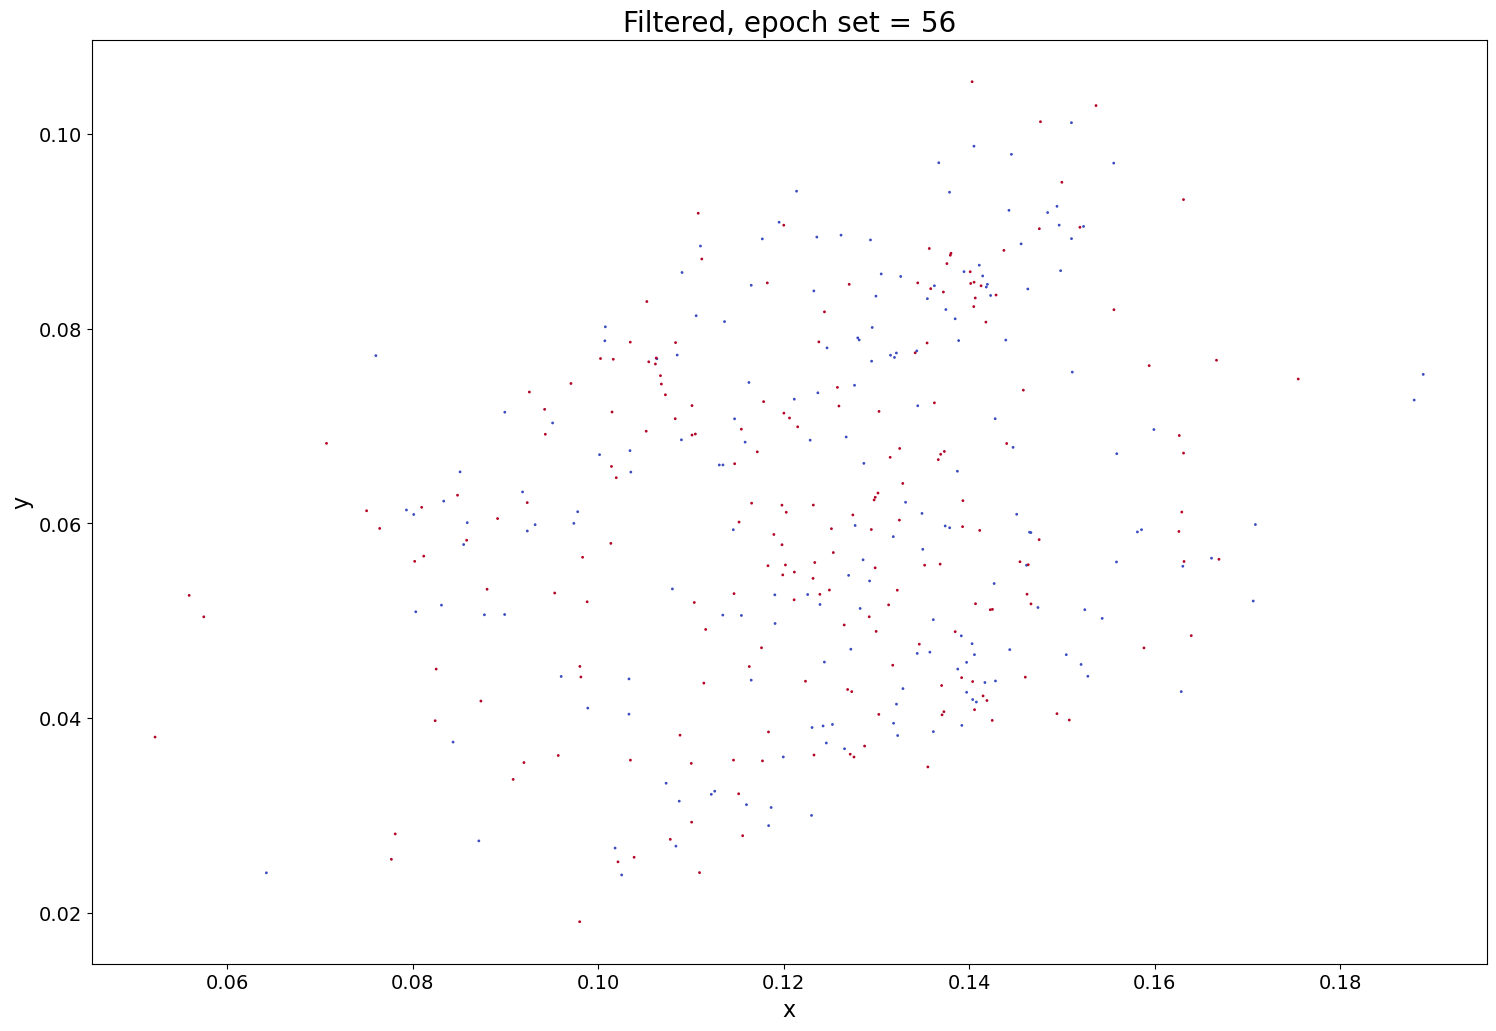

In [12]:
plt.figure(figsize=(18,12))
plt.scatter (latent.x,latent.y, c=latent.z, cmap="coolwarm", s = 1, alpha=1)
plt.title('Filtered, epoch set = 56', fontsize = 20)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize=16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize=14)
# plt.savefig("56_data.png", dpi = 300)

plt.show()

In [ ]:
# remove the trajectory identity column for further processing
latent_n = latent.drop(['z', 'index'], axis = 1)
print(latent_n)

In [ ]:
y_pred = DBSCAN(eps=0.015, min_samples=60).fit_predict(latent_n)
plt.rcParams['font.size'] = '18'
plt.figure(figsize=(18,10))
plt.scatter(latent_n.iloc[:,0], latent_n.iloc[:,1], c=y_pred,s = 1)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize=16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize=14)
plt.title('DBSCAN Clustering of the Latent Layer Representation of the Input data')
print('Number of clusters: {}'.format(len(set(y_pred[np.where(y_pred != -1)]))))

In [ ]:
# Add the cluster labels to your DataFrame
latent_n['cluster'] = y_pred

# Reattach the 'z' column
latent_n['z'] = latent['z']

# Group by cluster and trajectory identity, then count the occurrences
cluster_trajectory_count = latent_n.groupby(['cluster', 'z']).size().reset_index(name='count')

print(cluster_trajectory_count)

In [ ]:
# 0 is WT and 1 is D132H
cluster_trajectory_count['z'] = cluster_trajectory_count['z'].replace({0: 'WT', 1: 'D132H'})

# Create the bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='cluster', y='count', hue='z', data=cluster_trajectory_count)

# Setting labels and title
plt.xlabel('Cluster Number')
plt.ylabel('Number of Frames')
plt.title('Number of WT and D132H Frames in Each Cluster')
plt.xticks(rotation=0)
plt.legend(title='Trajectory Identity')

# Annotate each bar with its count
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

# Show the plot
plt.show()